In [ ]:
import json
import requests
import datetime
import numpy as np
import pandas as pd

def clean_data(df):
    """
    Inputs:
        df: data from API (straight from CSV saved after double loop below)
    Returns:
        new_df: cleaned DF (only average closing prices for each cryptocurrency)
    """
    # Set index.
    df.set_index('time', inplace=True)

    # Treat missing values.
    df.replace(0.0, np.nan, inplace=True)

    # Construct new features.
    df['volume'] = df['volumeto'] - df['volumefrom']
    df['fluctuation'] = (df['high']-df['low']) / (df['open'])
    df['relative_hl_close'] = (df['close']-df['low']) / (df['high']-df['low'])

    # Select only relevant columns.
    sub_df = df[['close','volume','fluctuation','relative_hl_close',
                 'exchange','fsym_tsym']]

    # Average over exchanges for all features.
    group_df = sub_df.groupby([sub_df.index,'fsym_tsym']).agg({'close':[np.nanmean],'volume':[np.nanmean],'fluctuation':[np.nanmean],'relative_hl_close':[np.nanmean]})

    # Drop an irrelevant label, construct hierarchical label for columns.
    group_df.columns = group_df.columns.droplevel(level=1)
    new_df = group_df.unstack(level='fsym_tsym')

    return new_df

def construct_url(params):
    """
    Build the URL associated with the call to the cryptocompare.com API.
    Input:
        params: (same as documented below in pull_data)
    Returns:
        url: URL for query
        sym_string: cryptocurrency identifier (just a label for later)
        exchange: (self-explanatory - also a label for later)
    """
    base_url = 'https://min-api.cryptocompare.com/data/histohour?'
    fsym, tsym = params['syms']
    agg = params['aggregate']
    lim = params['limit']
    exchange = params['exchange']

    ext_url = 'fsym=' + fsym + '&tsym=' + tsym + '&limit=' + lim + '&aggregate=' \
              + agg + '&e=' + exchange

    url = base_url + ext_url
    sym_string = fsym + '_' + tsym

    return url, sym_string, exchange

def dateparse(epoch_time):
    """
    Convert from epoch to human date (UTC).
    """
    return datetime.datetime.fromtimestamp(float(epoch_time))

def pull_data(params):
    """
    Call API using url generated by construct_url, add a few additional
    columns as labels.
    Inputs:
        params: parameters to pass in the query
            fsym: 'from' symbol (probably the cryptocurrency symbol)
            tsym: 'to' symbol (likely USD)
            limit: number of time points to return (max: 2000)
            e: exchange (Coinbase, Poloniex, etc. - refer to API documentation
               for an exhaustive list)
    Returns:
        data: data frame containing data from API call
    """

    url, s, e = construct_url(params)

    response = requests.get(url)
    response.raise_for_status()         # Raise exception if invalid response.
    json_response = response.json()

    data = pd.DataFrame(json_response['Data'])
    data['fsym_tsym'] = s
    data['exchange'] = e

    return data

exchanges = ['COINBASE', 'POLONIEX', 'KRAKEN', 'BITSTAMP', 'BITFINEX']
sym_pairs = [('BTC','USD'),('ETH','USD'), ('LTC','USD'), ('DASH','USD'),
             ('XMR','USD')]

full_df = pd.DataFrame() # initialize empty data frame
for sp in sym_pairs:
    for exc in exchanges:
        request_dict = {'syms': sp, 'aggregate': '1', 'limit':'2000',
                        'exchange': exc}
        df = pull_data(request_dict)

        if full_df.empty:
            full_df = df
        else:
            full_df = pd.concat([full_df, df], axis=0)

full_df.to_csv('crypto_data_all.csv', index=False)

# CLEANING CODE (uncomment if you want to do a bit of simplifying - modify the
# function clean_data above to suit your needs)
#
test = pd.read_csv('crypto_data_all.csv', parse_dates=['time'],
                   date_parser=dateparse)
x = clean_data(full_df) # change full_df to test if loading in crypto_data_all.csv
x.to_csv('cleaned_crypto_all_features.csv')

In [ ]:
x

close                                               volume  \
fsym_tsym       BTC_USD DASH_USD   ETH_USD LTC_USD     XMR_USD       BTC_USD   
time                                                                           
1.662178e+09  17212.852  72.9550  1291.828  59.302  136.456667  1.794252e+06   
1.662181e+09  17227.692  73.0500  1296.516  59.026  136.546667  1.458541e+06   
1.662185e+09  17184.116  72.9800  1291.450  58.586  136.426667  1.921433e+06   
1.662188e+09  17124.820  72.4975  1275.178  57.922  135.886667  3.728268e+06   
1.662192e+09  17100.564  72.5925  1275.142  58.126  136.303333  3.185589e+06   
...                 ...      ...       ...     ...         ...           ...   
1.669363e+09  14422.090  68.9975   983.624  70.008  123.823333  2.766997e+06   
1.669367e+09  14415.702  68.9075   982.062  69.706  124.450000  2.994356e+06   
1.669370e+09  14442.686  69.2150   986.926  69.876  124.800000  4.634412e+06   
1.669374e+09  14484.424  69.3625   993.622  70.862  124.716667  6.176081e+06   
1.669378e+09  14520.456  69.3450   997.000  71.006  124.686667  2.256401e+06   

                                                                  fluctuation  \
fsym_tsym        DASH_USD       ETH_USD      LTC_USD      XMR_USD     BTC_USD   
time                                                                            
1.662178e+09  3620.183333  1.865480e+06  170911.3625    3437.6185    0.001858   
1.662181e+09  3031.470000  1.753212e+06  270863.9225    6757.3400    0.001572   
1.662185e+09  4479.026667  1.732264e+06  222730.7325   26701.6300    0.004855   
1.662188e+09  8161.026667  6.632888e+06  356264.1450  107890.1900    0.006078   
1.662192e+09  2918.856667  5.286312e+06  202921.9525    8057.3600    0.003447   
...                   ...           ...          ...          ...         ...   
1.669363e+09  4378.700000  2.484392e+06  360640.6950   14828.1750    0.003151   
1.669367e+09  3807.306667  2.575693e+06  238849.1625   12567.1300    0.001959   
1.669370e+09  2603.306667  3.218527e+06  548260.2000    9601.5720    0.005031   
1.669374e+09  4876.026333  4.960450e+06  484403.8525   27980.9050    0.005392   
1.669378e+09  1509.075000  1.630234e+06  277386.3075   13514.1195    0.002400   

                                                     relative_hl_close  \
fsym_tsym     DASH_USD   ETH_USD   LTC_USD   XMR_USD           BTC_USD   
time                                                                     
1.662178e+09  0.003716  0.004802  0.011674  0.003100          0.814019   
1.662181e+09  0.002881  0.003913  0.011941  0.002718          0.500227   
1.662185e+09  0.005746  0.006720  0.011292  0.005127          0.514498   
1.662188e+09  0.014231  0.016974  0.020293  0.006785          0.395703   
1.662192e+09  0.004628  0.006351  0.013749  0.003695          0.229492   
...                ...       ...       ...       ...               ...   
1.669363e+09  0.011281  0.005393  0.011637  0.006812          0.362857   
1.669367e+09  0.003868  0.004890  0.008432  0.006126          0.144402   
1.669370e+09  0.011518  0.008485  0.014891  0.005172          0.630198   
1.669374e+09  0.009817  0.009330  0.016556  0.004000          0.498954   
1.669378e+09  0.002850  0.003661  0.005665  0.001916          0.979287   

                                                      
fsym_tsym     DASH_USD   ETH_USD   LTC_USD   XMR_USD  
time                                                  
1.662178e+09  1.000000  0.697720  0.770737  1.000000  
1.662181e+09  0.827381  0.779834  0.250726  0.538084  
1.662185e+09  0.330743  0.459898  0.346943  0.512496  
1.662188e+09  0.235946  0.316707  0.311414  0.469231  
1.662192e+09  0.462679  0.377317  0.749177  0.737665  
...                ...       ...       ...       ...  
1.669363e+09  0.185529  0.214334  0.569290  0.493617  
1.669367e+09  0.339835  0.301790  0.145522  1.000000  
1.669370e+09  1.000000  0.716132  0.954932  1.000000  
1.669374e+09  0.383542  0.618735  0.794026  0.067846  
1.669378e+

In [ ]:
# Import statements (standard)
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
sns.set_style('white')


# Import statements (stats)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
#from pandas.plotting import autocorrelation_plot as acf_pl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('/content/cleaned_crypto_all_features.csv', header=[0,1], skiprows=[2], index_col=0)


In [ ]:
df.head()

close                                               volume  \
fsym_tsym       BTC_USD DASH_USD   ETH_USD LTC_USD     XMR_USD       BTC_USD   
1.662232e+09  17037.182  73.3375  1279.136  58.402  136.470000  6.334525e+06   
1.662235e+09  17062.674  73.4050  1281.686  58.828  137.206667  2.508955e+06   
1.662239e+09  17068.936  73.4650  1281.606  58.674  136.993333  1.256458e+06   
1.662242e+09  17105.066  73.5350  1284.158  57.878  137.320000  2.722870e+06   
1.662246e+09  17137.074  73.5150  1285.542  57.994  137.130000  1.493961e+06   

                                                                fluctuation  \
fsym_tsym        DASH_USD       ETH_USD      LTC_USD    XMR_USD     BTC_USD   
1.662232e+09  5832.996667  3.864627e+06  189328.3525   3189.360    0.006559   
1.662235e+09  2475.453000  1.455505e+06  108425.2825  23604.635    0.002613   
1.662239e+09   694.490233  1.670124e+06   68560.4175   5795.195    0.001817   
1.662242e+09  8291.766667  2.316323e+06  244505.4700   3115.569    0.003012   
1.662246e+09  2639.035000  1.078019e+06  146337.6825  15930.744    0.003321   

                                                     relative_hl_close  \
fsym_tsym     DASH_USD   ETH_USD   LTC_USD   XMR_USD           BTC_USD   
1.662232e+09  0.008202  0.014054  0.009018  0.003348          0.342669   
1.662235e+09  0.003549  0.003486  0.007746  0.006217          0.929518   
1.662239e+09  0.001932  0.002600  0.003627  0.002806          0.436304   
1.662242e+09  0.002679  0.004254  0.014586  0.003244          0.613966   
1.662246e+09  0.002460  0.004076  0.005764  0.002673          0.878438   

                                                      
fsym_tsym     DASH_USD   ETH_USD   LTC_USD   XMR_USD  
1.662232e+09  0.524020  0.490678  0.250102  0.333333  
1.662235e+09  0.614795  0.871229  1.000000  0.774172  
1.662239e+09  0.933333  0.190841  0.036765  0.242632  
1.662242e+09  0.653846  0.403211  0.017356  0.656517  
1.662246e+09  0.407407  0.918929  0.945273  0.540417

In [ ]:
df.index.name = 'fsym_time'


In [ ]:
df.index

Float64Index([1662177600.0, 1662181200.0, 1662184800.0, 1662188400.0,
              1662192000.0, 1662195600.0, 1662199200.0, 1662202800.0,
              1662206400.0, 1662210000.0,
              ...
              1669345200.0, 1669348800.0, 1669352400.0, 1669356000.0,
              1669359600.0, 1669363200.0, 1669366800.0, 1669370400.0,
              1669374000.0, 1669377600.0],
             dtype='float64', name='fsym_time', length=2001)

In [ ]:
df.index = pd.to_datetime(df.index.astype(int))
df = df[:-1].astype(float)

In [ ]:
df.index

DatetimeIndex(['1970-01-01 00:00:01.662177600',
               '1970-01-01 00:00:01.662181200',
               '1970-01-01 00:00:01.662184800',
               '1970-01-01 00:00:01.662188400',
                  '1970-01-01 00:00:01.662192',
               '1970-01-01 00:00:01.662195600',
               '1970-01-01 00:00:01.662199200',
               '1970-01-01 00:00:01.662202800',
               '1970-01-01 00:00:01.662206400',
                  '1970-01-01 00:00:01.662210',
               ...
               '1970-01-01 00:00:01.669341600',
               '1970-01-01 00:00:01.669345200',
               '1970-01-01 00:00:01.669348800',
               '1970-01-01 00:00:01.669352400',
                  '1970-01-01 00:00:01.669356',
               '1970-01-01 00:00:01.669359600',
               '1970-01-01 00:00:01.669363200',
               '1970-01-01 00:00:01.669366800',
               '1970-01-01 00:00:01.669370400',
                  '1970-01-01 00:00:01.669374'],
              dtype=

In [ ]:
train_end = pd.to_datetime('2017/11/30 12:00:00')
test_start = pd.to_datetime('2017/11/30 13:00:00')
crypto_str = 'ETH_USD'

sub_df = df.xs(crypto_str, level='fsym_tsym', axis=1)
train_df = sub_df.loc[:train_end]
train_prices = train_df.close
test_df = sub_df.loc[test_start:] 
test_prices = test_df.close
all_prices = sub_df.close

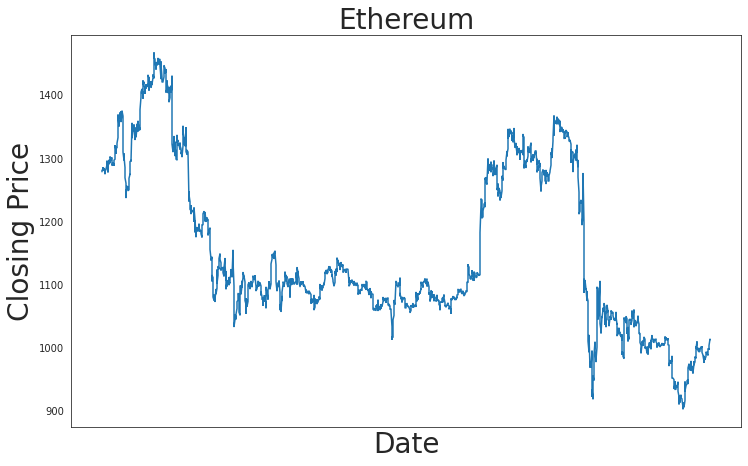

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
_ = sub_df.close.plot(ax=ax)
_ = plt.xlabel('Date', size=28)
_ = plt.ylabel('Closing Price', size=28)
_ = plt.title('Ethereum', size=28)

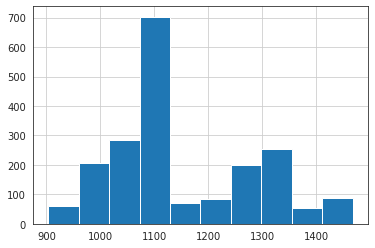

In [ ]:
#histogram
sub_df['close'].hist()

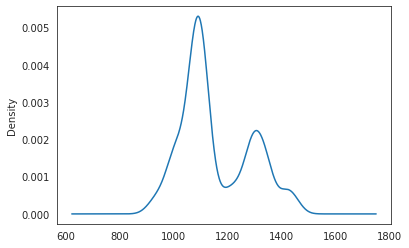

In [ ]:
#density plot
sub_df['close'].plot(kind='kde')
#A density plot is a representation of the distribution of a numeric variable.  It is a smoothed version of the histogram and is used in the same concept.
#If a density curve is left skewed, then the mean is less than the median.
#If a density curve is right skewed, then the mean is greater than the median.
#If a density curve has no skew, then the mean is equal to the median.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


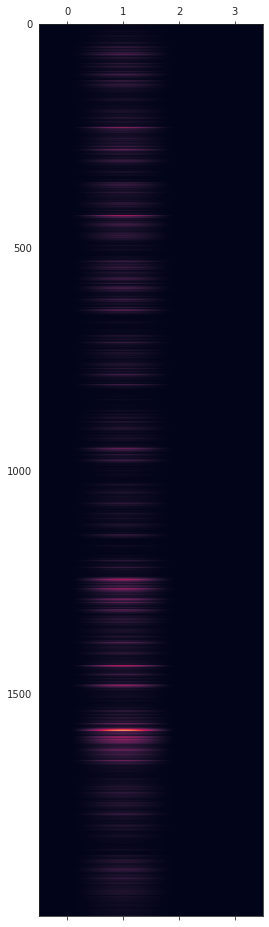

In [ ]:
from pandas import Grouper,concat,DataFrame
one_year = sub_df['1970']
groups = one_year.groupby(Grouper(freq='D'))
hours = concat([DataFrame(x[1].values) for x in groups], axis=1)
hours = DataFrame(hours)
hours.columns = range(1,5)
plt.matshow(hours, interpolation=None, aspect='auto')
plt.show()

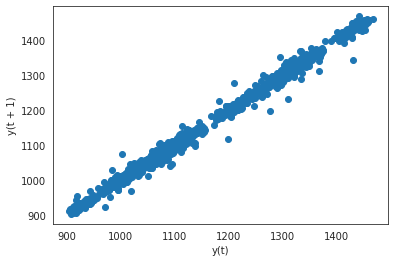

In [ ]:
from pandas.plotting import lag_plot
lag_plot(sub_df['close'])

This graph depects strong autocorrelation between the time series data

fsym_time
1970-01-01 00:00:01.662231600            NaN
1970-01-01 00:00:01.662235200            NaN
1970-01-01 00:00:01.662238800    1280.809333
1970-01-01 00:00:01.662242400    1282.483333
1970-01-01 00:00:01.662246000    1283.768667
1970-01-01 00:00:01.662249600    1285.106000
1970-01-01 00:00:01.662253200    1284.959333
1970-01-01 00:00:01.662256800    1283.948667
1970-01-01 00:00:01.662260400    1282.429333
1970-01-01 00:00:01.662264000    1282.664000
Name: close, dtype: float64


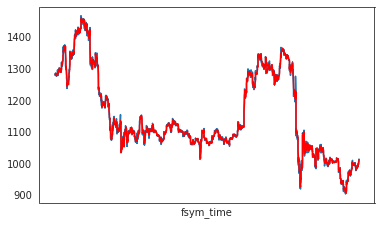

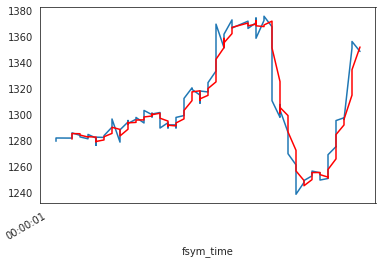

In [ ]:
rolling = sub_df['close'].rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
sub_df['close'].plot()
rolling_mean.plot(color='red')
plt.show()
# zoomed plot original and transformed dataset
sub_df['close'][:100].plot()
rolling_mean[:100].plot(color='red')
plt.show()

Resampling refers to change the frequency of time series observations. Resampling includes upsampling and downsampling. Upsampling means we increase the frequency of the sample, and downsampling means we decrease the frequency of the sample.

In [ ]:
def adf_stationarity_test(df, al=None, nl=1):
    if al is None:
        results = adfuller(df, maxlag=nl)
    else:
        results = adfuller(df, autolag=al)

    formatted_results = pd.Series({'Test Statistic': results[0], 'p-value':
                                   results[1], 'Number of Lags': results[2],
                                   'Number of Data Points': results[3]})

    return formatted_results

In [ ]:
def difference_prices(df, order=1):
    diff_df = df.diff(periods=order)
    diff_df = diff_df.dropna()

    return diff_df

In [ ]:
print('All:')
adf_stationarity_test(all_prices, al='AIC')

All:


Test Statistic             -1.702672
p-value                     0.429736
Number of Lags              8.000000
Number of Data Points    1991.000000
dtype: float64

Closing Prices (first differenced)

In [ ]:
train_diff_prices = difference_prices(train_prices)
test_diff_prices = difference_prices(test_prices)
all_diff_prices = difference_prices(all_prices)

In [ ]:
print('All:')
adf_stationarity_test(all_diff_prices, al='AIC')

All:


Test Statistic          -1.447653e+01
p-value                  6.475793e-27
Number of Lags           7.000000e+00
Number of Data Points    1.991000e+03
dtype: float64

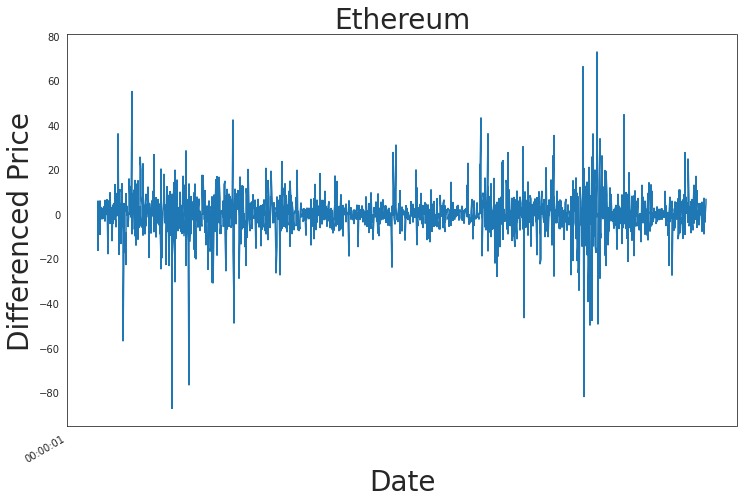

In [ ]:
# Plot all differenced prices.
fig, ax = plt.subplots(figsize=(12,8))
_ = all_diff_prices.plot(ax=ax)
_ = plt.xlabel('Date', size=28)
_ = plt.ylabel('Differenced Price', size=28)
_ = plt.title('Ethereum', size=28)

In [ ]:
# Experiment with Box-Cox transformation.
from scipy.stats import boxcox

shift = 50.
shifted_diff_prices = all_diff_prices + shift

bc_diff_prices, lmbda = boxcox(abs(shifted_diff_prices))
bc_df = pd.DataFrame(bc_diff_prices)
bc_df.set_index(all_diff_prices.index, inplace=True)

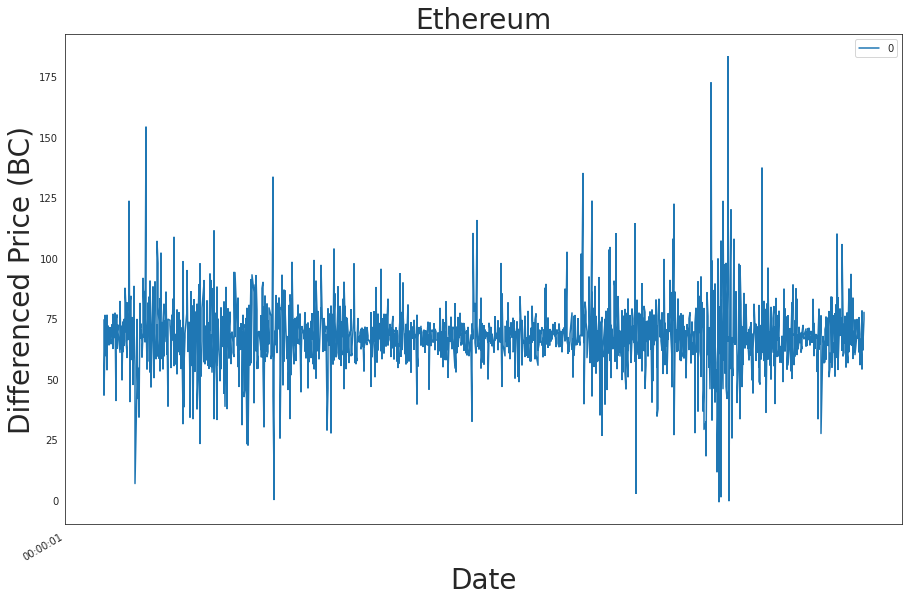

In [ ]:
# Plot differenced prices after box cox transformation.
fig, ax = plt.subplots(figsize=(15,10))
_ = bc_df.plot(ax=ax)
_ = plt.xlabel('Date', size=28)
_ = plt.ylabel('Differenced Price (BC)', size=28)
_ = plt.title('Ethereum', size=28)

UPSAMPLING AND DOWNSAMPLING

In [44]:
df['close']

fsym_tsym,BTC_USD,DASH_USD,ETH_USD,LTC_USD,XMR_USD
fsym_time,,,,,
1970-01-01 00:00:01.662231600,17037.182,73.3375,1279.136,58.402,136.470000
1970-01-01 00:00:01.662235200,17062.674,73.4050,1281.686,58.828,137.206667
1970-01-01 00:00:01.662238800,17068.936,73.4650,1281.606,58.674,136.993333
1970-01-01 00:00:01.662242400,17105.066,73.5350,1284.158,57.878,137.320000
1970-01-01 00:00:01.662246000,17137.074,73.5150,1285.542,57.994,137.130000
...,...,...,...,...,...
1970-01-01 00:00:01.669413600,14484.954,68.7475,998.312,68.668,124.930000
1970-01-01 00:00:01.669417200,14478.000,68.8100,998.026,69.096,125.210000
1970-01-01 00:00:01.669420800,14523.538,69.1175,1004.050,69.560,125.593333


In [60]:
resampled = sub_df.resample('0.0000001S').mean()
resampled['close'].head(25)

fsym_time
1970-01-01 00:00:01.662231600    1279.136
1970-01-01 00:00:01.662231700         NaN
1970-01-01 00:00:01.662231800         NaN
1970-01-01 00:00:01.662231900         NaN
1970-01-01 00:00:01.662232000         NaN
1970-01-01 00:00:01.662232100         NaN
1970-01-01 00:00:01.662232200         NaN
1970-01-01 00:00:01.662232300         NaN
1970-01-01 00:00:01.662232400         NaN
1970-01-01 00:00:01.662232500         NaN
1970-01-01 00:00:01.662232600         NaN
1970-01-01 00:00:01.662232700         NaN
1970-01-01 00:00:01.662232800         NaN
1970-01-01 00:00:01.662232900         NaN
1970-01-01 00:00:01.662233000         NaN
1970-01-01 00:00:01.662233100         NaN
1970-01-01 00:00:01.662233200         NaN
1970-01-01 00:00:01.662233300         NaN
1970-01-01 00:00:01.662233400         NaN
1970-01-01 00:00:01.662233500         NaN
1970-01-01 00:00:01.662233600         NaN
1970-01-01 00:00:01.662233700         NaN
1970-01-01 00:00:01.662233800         NaN
1970-01-01 00:00:01.6622

In [63]:
interpolated = resampled.interpolate(method='linear', order=2)
interpolated.head(30)

,close,volume,fluctuation,relative_hl_close
fsym_time,,,,
1970-01-01 00:00:01.662231600,1279.136000,3.864627e+06,0.014054,0.490678
1970-01-01 00:00:01.662231700,1279.206833,3.797707e+06,0.013761,0.501249
1970-01-01 00:00:01.662231800,1279.277667,3.730787e+06,0.013467,0.511820
1970-01-01 00:00:01.662231900,1279.348500,3.663867e+06,0.013173,0.522390
1970-01-01 00:00:01.662232000,1279.419333,3.596947e+06,0.012880,0.532961
1970-01-01 00:00:01.662232100,1279.490167,3.530027e+06,0.012586,0.543532
1970-01-01 00:00:01.662232200,1279.561000,3.463106e+06,0.012293,0.554103
1970-01-01 00:00:01.662232300,1279.631833,3.396186e+06,0.011999,0.564674
1970-01-01 00:00:01.662232400,1279.702667,3.329266e+06,0.011706,0.575245


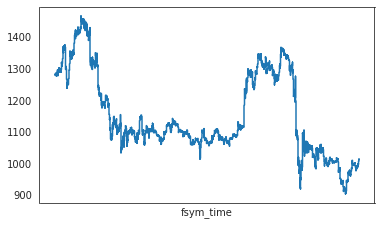

In [65]:
interpolated['close'].plot()
plt.show()
